# Dataset Overview

let check overview of the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
train_df.drop_duplicates(inplace=True)

In [4]:
# train_df.head().T

In [5]:
#Target Distribution
# train_df['class'].value_counts()

In [6]:
#Data Summary
# train_df.describe(include='all').T

# Clean Dataset
Dataset contain a lot of contrived values and so let try clean and see the result.

In [7]:
from sklearn.preprocessing import LabelEncoder


#get outlier limit
def get_outlier_range(sr):
    Q3 = sr.quantile(0.75)
    Q1 = sr.quantile(0.25)
    IQR = Q3-Q1
    upper = Q3+(1.5*IQR)
    lower = Q1-(1.5*IQR)
    return lower,upper


#let define some helper function
def clean_data(df):
    #feature columns
    if 'class' in df.columns:
        df = df.drop(columns=['id'])
        feat_cols = df.drop(columns=['class']).columns

#         modify target data to numerical 
        df['class'],_ = df['class'].factorize()
        
    else:
#         df = df.drop(columns=['veil-type'])
        feat_cols = df.drop(columns='id').columns
    
    #category columns
    cat_cols = set([x if y=='object' else np.nan for x,y in zip(feat_cols,df[feat_cols].dtypes)])
    cat_cols.remove(np.nan)
    cat_cols = list(cat_cols)
    cat_cols.sort()
    
    #numerial columns
    num_cols = df[feat_cols].drop(columns=cat_cols).columns
    
    #replace missing values with np.nan
    df = df.fillna(np.nan)
    
    
    #get dictionay of relevant values 
    values ={}
    for col in cat_cols:
#         values[col] = list(df[col].value_counts().apply(lambda x : x if x >100 else np.nan).dropna().index)+['missing']
        values[col] = list(df[col].value_counts().apply(lambda x : x if x >100 else np.nan).dropna().index)+[np.nan]
        

    #modify values with non-relevant values
    for col in cat_cols:
#         df[col] = df[col].fillna('missing')
        df.loc[~df[col].isin(values[col]),col]=np.nan
    
#     #get upper_limit values
#     upper_list = {}
#     for col in num_cols:
#         _,upper_list[col]= get_outlier_range(df[col])

        
        
    #remove rows with outlier values
    for col in num_cols:
        df[col] = pd.qcut(df[col],7,duplicates='drop')
        
#     for col in feat_cols:
#         df[col],_ = pd.factorize(df[col],use_na_sentinel=True)
    

    

    one_hot = pd.get_dummies(df[feat_cols],dummy_na=False,dtype=np.uint8)
    df = pd.concat([df.drop(columns=feat_cols),one_hot],axis=1)


    return df

# Pre-process Data

In [8]:
train  = clean_data(train_df)

In [9]:
col_list = list(train.columns)

In [10]:
col_list

['class',
 'cap-diameter_(0.028999999999999998, 2.44]',
 'cap-diameter_(2.44, 3.55]',
 'cap-diameter_(3.55, 4.84]',
 'cap-diameter_(4.84, 6.41]',
 'cap-diameter_(6.41, 7.84]',
 'cap-diameter_(7.84, 9.95]',
 'cap-diameter_(9.95, 80.67]',
 'cap-shape_b',
 'cap-shape_c',
 'cap-shape_f',
 'cap-shape_o',
 'cap-shape_p',
 'cap-shape_s',
 'cap-shape_x',
 'cap-surface_d',
 'cap-surface_e',
 'cap-surface_g',
 'cap-surface_h',
 'cap-surface_i',
 'cap-surface_k',
 'cap-surface_l',
 'cap-surface_s',
 'cap-surface_t',
 'cap-surface_w',
 'cap-surface_y',
 'cap-color_b',
 'cap-color_e',
 'cap-color_g',
 'cap-color_k',
 'cap-color_l',
 'cap-color_n',
 'cap-color_o',
 'cap-color_p',
 'cap-color_r',
 'cap-color_u',
 'cap-color_w',
 'cap-color_y',
 'does-bruise-or-bleed_f',
 'does-bruise-or-bleed_t',
 'gill-attachment_a',
 'gill-attachment_d',
 'gill-attachment_e',
 'gill-attachment_f',
 'gill-attachment_p',
 'gill-attachment_s',
 'gill-attachment_x',
 'gill-spacing_c',
 'gill-spacing_d',
 'gill-spacing_

In [11]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY = train_test_split(train.drop(columns=['class']),train['class'],test_size=0.01,shuffle=True,stratify=train['class'])

# Ensemble

In [12]:
import tensorflow as tf
import tf_keras

input_size = trainX.shape[1]

#Input features
inputs = tf_keras.Input(shape=(input_size,))

#model1
m1_dense1 = tf_keras.layers.Dense(512,activation='relu')(inputs)
m1_dropout1 = tf_keras.layers.Dropout(0.2)(m1_dense1)
m1_dense2 = tf_keras.layers.Dense(512,activation='relu')(m1_dropout1)
m1_dropout2 = tf_keras.layers.Dropout(0.2)(m1_dense2)
m1_dense3 = tf_keras.layers.Dense(512,activation='relu')(m1_dropout2)
m1_dropout3 = tf_keras.layers.Dropout(0.2)(m1_dense3)
m1_pred = tf_keras.layers.Dense(1, activation='sigmoid')(m1_dropout3)

#model2
m2_dense1 = tf_keras.layers.Dense(512,activation='relu')(inputs)
m2_gnoise1 = tf_keras.layers.GaussianNoise(0.05)(m2_dense1)
m2_dense2 = tf_keras.layers.Dense(512,activation='relu')(m2_gnoise1)
m2_gnoise2 = tf_keras.layers.GaussianNoise(0.01)(m2_dense2)
m2_dense3 = tf_keras.layers.Dense(512,activation='relu')(m2_gnoise2)
m2_dropout1 = tf_keras.layers.Dropout(0.2)(m2_dense3)
m2_pred = tf_keras.layers.Dense(1, activation='sigmoid')(m2_dropout1)

#model3

m3_activity_regu = tf_keras.layers.ActivityRegularization(l1=0.0001, l2=0.0001)(inputs)
m3_dense1 = tf_keras.layers.Dense(512,activation='relu')(m3_activity_regu)
m3_gnoise1 = tf_keras.layers.GaussianNoise(0.01)(m3_dense1)
m3_dense2 = tf_keras.layers.Dense(512,activation='relu')(m3_gnoise1)
m3_drop1 = tf_keras.layers.Dropout(0.01)(m3_dense2)
m3_dense3 = tf_keras.layers.Dense(512,activation='relu')(m3_drop1)
m3_drop2 = tf_keras.layers.Dropout(0.2)(m3_dense3)
m3_pred = tf_keras.layers.Dense(1, activation='sigmoid')(m3_drop2)

#combine model
mean_nn = tf.reduce_mean(tf.stack([m1_pred, m2_pred,m3_pred], axis=0), axis=0)
ensemble_model = tf_keras.models.Model(inputs, mean_nn)


2024-08-30 07:38:08.150654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 07:38:08.150814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 07:38:08.314354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
# import tensorflow as tf

# def get_model():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.Input(shape=(trainX.shape[1],)))
#     model.add(tf.keras.layers.Dense(512,activation='relu'))
#     model.add(tf.keras.layers.GaussianNoise(0.05))
#     model.add(tf.keras.layers.Dense(512,activation='relu'))
    
    
#     model.add(tf.keras.layers.Dense(512,activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.2))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
# # model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])
#     return model


In [14]:
# model = get_model()
ensemble_model.compile(loss=tf_keras.losses.BinaryCrossentropy(), optimizer=tf_keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 137)]                0         []                            
                                                                                                  
 activity_regularization (A  (None, 137)                  0         ['input_1[0][0]']             
 ctivityRegularization)                                                                           
                                                                                                  
 dense (Dense)               (None, 512)                  70656     ['input_1[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 512)                  70656     ['input_1[0][0]']         

In [18]:
# #Train Model

hist = ensemble_model.fit(trainX,trainY,epochs=100,batch_size=64,validation_split=0.02,callbacks=[tf_keras.callbacks.EarlyStopping(patience=1,monitor='val_loss')])

Epoch 1/100
47251/47251 [==============================] - 979s 20ms/step - loss: 0.0501 - accuracy: 0.9887 - val_loss: 0.0429 - val_accuracy: 0.9914
Epoch 2/100
47251/47251 [==============================] - 951s 20ms/step - loss: 0.0410 - accuracy: 0.9919 - val_loss: 0.0423 - val_accuracy: 0.9916
Epoch 3/100
47251/47251 [==============================] - 947s 20ms/step - loss: 0.0401 - accuracy: 0.9921 - val_loss: 0.0416 - val_accuracy: 0.9918
Epoch 4/100
47251/47251 [==============================] - 945s 20ms/step - loss: 0.0395 - accuracy: 0.9922 - val_loss: 0.0416 - val_accuracy: 0.9918


# Evaluate Model

In [20]:
y_pred_raw = ensemble_model.predict(testX)

975/975 [==============================] - 6s 5ms/step


In [21]:
from sklearn.metrics import matthews_corrcoef
y_pred = [0 if x<=0.5 else 1 for x in y_pred_raw]
matthews_corrcoef(testY,y_pred)

0.9851794568179821

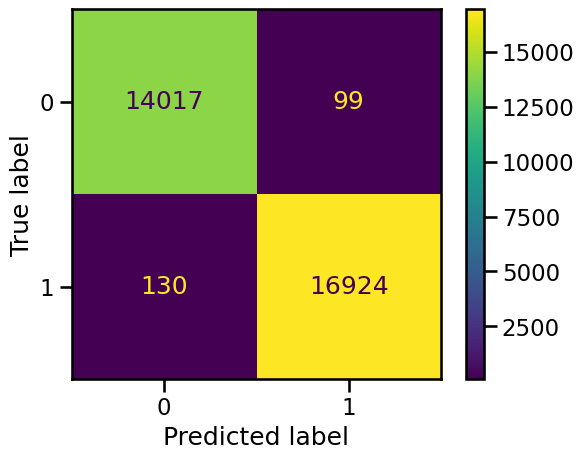

In [22]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
cf = confusion_matrix(testY, y_pred)
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()
plt.show()

# Submission

In [23]:
#pre-process data
test = clean_data(test_df)

In [24]:
test.head()

,id,"cap-diameter_(-0.001, 2.43]","cap-diameter_(2.43, 3.54]","cap-diameter_(3.54, 4.83]","cap-diameter_(4.83, 6.41]","cap-diameter_(6.41, 7.84]","cap-diameter_(7.84, 9.95]","cap-diameter_(9.95, 607.0]",cap-shape_b,cap-shape_c,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,3116945,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3116946,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3116947,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,3116948,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3116949,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# pred =[]
# for model in model_list:
#     pred.append([0 if x<=0.5 else 1 for x in model.predict(test.drop(columns=['id'])).squeeze()])

In [ ]:
# sub = pd.DataFrame(['p' if x==1 else 'e' for x in np.median(pred,axis=0) ],index=test['id'],columns=['class'])
# sub.to_csv('submission.csv')

In [25]:
pred = ensemble_model.predict(test.drop(columns=['id'])).squeeze()
pred

64937/64937 [==============================] - 281s 4ms/step


array([0.00193603, 0.9946907 , 0.9928417 , ..., 0.9925203 , 0.00438218,
       0.00231445], dtype=float32)

In [28]:
sub = pd.DataFrame(['p' if x>0.5 else 'e' for x in pred],index=test['id'],columns=['class'])
sub.to_csv('submission.csv')

In [29]:
!head submission.csv

id,class
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p
